# 9. Normalization Methods

Training deep networks is hard because the distribution of inputs to each layer changes during training.
This is called **Internal Covariate Shift**.
Normalization fixes this by forcing layer inputs to have mean 0 and variance 1.

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## 1. The Problem: Internal Covariate Shift

Before we fix it, let's see the problem.
As data flows through a deep network, the distribution of activations (mean and variance) changes.
This forces later layers to constantly adapt to new distributions, slowing down training.

Let's visualize this shift in a 20-layer network.

--- Without Normalization ---
Layer 1: Mean=0.0047, Std=0.5766
Layer 10: Mean=0.0049, Std=0.0668
Layer 20: Mean=0.0019, Std=0.0788


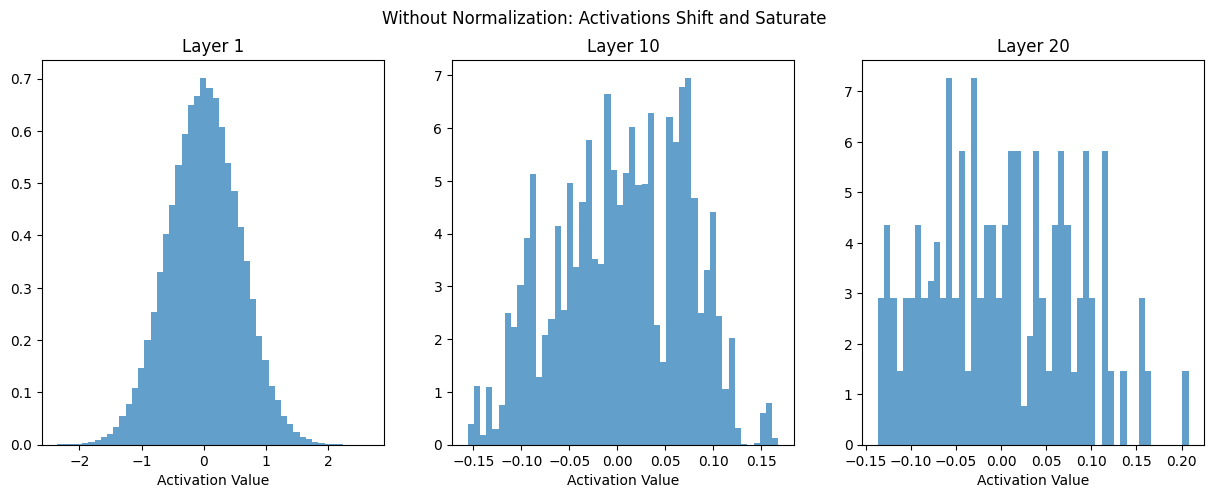

In [7]:
def visualize_activations(model, title):
    x = torch.randn(1000, 100) # Batch of 1000 samples
    activations = []
    
    with torch.no_grad():
        for layer in model:
            x = layer(x)
            if isinstance(layer, nn.Linear):
                activations.append(x.view(-1).numpy())
    
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    # Plot histogram for specific layers
    layers_to_plot = [0, 9, 19] # Layer 1, 10, 20
    for i, layer_idx in enumerate(layers_to_plot):
        plt.subplot(1, 3, i+1)
        plt.hist(activations[layer_idx], bins=50, density=True, alpha=0.7)
        plt.title(f"Layer {layer_idx+1}")
        plt.xlabel("Activation Value")
        
        # Print stats
        mean = np.mean(activations[layer_idx])
        std = np.std(activations[layer_idx])
        print(f"Layer {layer_idx+1}: Mean={mean:.4f}, Std={std:.4f}")
    plt.show()

# Create a deep network WITHOUT normalization
layers = []
for _ in range(20):
    layers.append(nn.Linear(100, 100))
    layers.append(nn.Tanh()) # Tanh activation

deep_net = nn.Sequential(*layers)

print("--- Without Normalization ---")
visualize_activations(deep_net, "Without Normalization: Activations Shift and Saturate")

# Notice how the distribution spreads out or collapses?
# If it spreads too much (saturates Tanh), gradients become 0.
# If it collapses to 0, the network stops learning.

## 2. The Solution: Normalization

Now let's see what happens if we force the inputs to each layer to be Gaussian (Mean=0, Std=1).


--- With Batch Normalization ---
Layer 1: Mean=-0.0021, Std=0.5825
Layer 10: Mean=0.0009, Std=0.3677
Layer 20: Mean=-0.0002, Std=0.3670


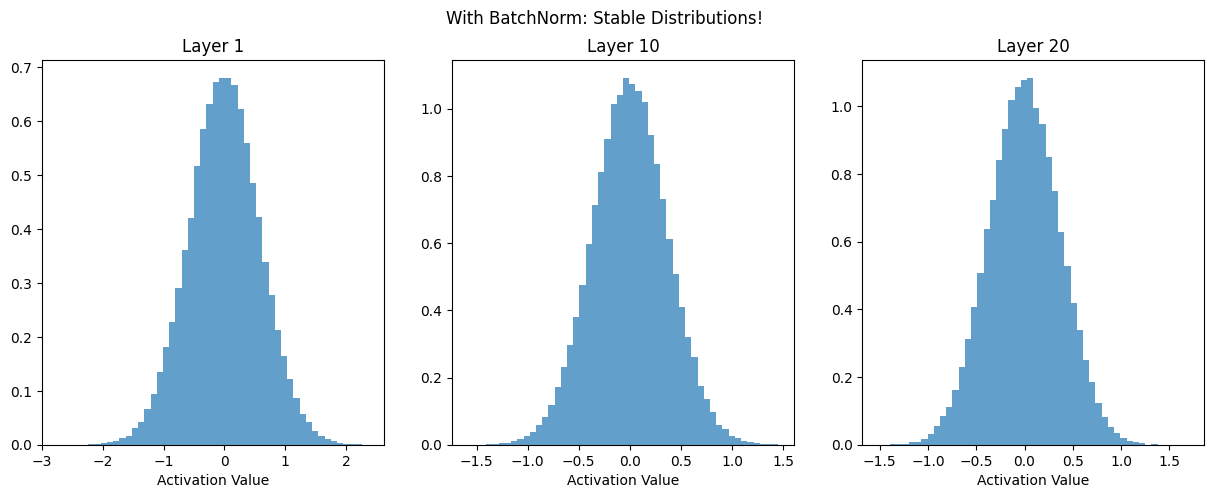

In [8]:
# Create a deep network WITH BatchNorm
layers_bn = []
for _ in range(20):
    layers_bn.append(nn.Linear(100, 100))
    layers_bn.append(nn.BatchNorm1d(100)) # Add BatchNorm
    layers_bn.append(nn.Tanh())

deep_net_bn = nn.Sequential(*layers_bn)

print("\n--- With Batch Normalization ---")
visualize_activations(deep_net_bn, "With BatchNorm: Stable Distributions!")

# Notice how the distributions stay consistent across all layers?
# This allows the network to train much faster and deeper!

## 3. Batch Normalization (BatchNorm)

Normalizes features **across the batch**.

For a batch of $N$ samples with $D$ features:
1. Calculate mean $\mu_j$ and variance $\sigma_j^2$ for each feature $j$ (across $N$ samples).
2. Normalize: $\hat{x}_{ij} = \frac{x_{ij} - \mu_j}{\sqrt{\sigma_j^2 + \epsilon}}$
3. Scale and Shift: $y_{ij} = \gamma_j \hat{x}_{ij} + \beta_j$

$\gamma$ and $\beta$ are learnable parameters!

In [9]:
class CustomBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        
        # Learnable parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        
        # Running stats (not trained, but updated)
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        if self.training:
            # 1. Calculate batch stats
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            
            # 2. Update running stats (Exponential Moving Average)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            # Use running stats during inference
            mean = self.running_mean
            var = self.running_var
            
        # 3. Normalize
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        
        # 4. Scale and Shift
        out = self.gamma * x_norm + self.beta
        return out

# Test it
batch_size = 3
features = 5
x = torch.randn(batch_size, features) * 10 + 5 # Mean ~5, Var ~100

bn = CustomBatchNorm1d(features)
out = bn(x)

print(f"Input Mean: {x.mean(dim=0)}")
print(f"Output Mean: {out.mean(dim=0)} (Should be close to 0)")
print(f"Output Var: {out.var(dim=0, unbiased=False)} (Should be close to 1)")

Input Mean: tensor([ 2.8582,  1.5563,  3.3762,  3.5285, -5.3139])
Output Mean: tensor([ 0.0000e+00, -3.9736e-08,  0.0000e+00, -3.9736e-08,  0.0000e+00],
       grad_fn=<MeanBackward1>) (Should be close to 0)
Output Var: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>) (Should be close to 1)


## 4. Layer Normalization (LayerNorm)

Normalizes features **across the sample**.
Independent of batch size. Great for RNNs and Transformers.

For each sample $i$:
1. Calculate mean $\mu_i$ and variance $\sigma_i^2$ across all $D$ features.
2. Normalize using these sample-specific stats.

In [10]:
ln = nn.LayerNorm(features)
out_ln = ln(x)

# Check stats per sample (dim=1)
print(f"LayerNorm Output Mean (per sample): {out_ln.mean(dim=1)}")
print(f"LayerNorm Output Var (per sample): {out_ln.var(dim=1, unbiased=False)}")

LayerNorm Output Mean (per sample): tensor([-2.3842e-08, -4.7684e-08,  2.3842e-08], grad_fn=<MeanBackward1>)
LayerNorm Output Var (per sample): tensor([1.0000, 1.0000, 1.0000], grad_fn=<VarBackward0>)


## 5. When to use what?

- **BatchNorm**: Default for CNNs and Feed-Forward Networks. Needs decent batch size (>32).
- **LayerNorm**: Default for Transformers (BERT, GPT) and RNNs. Works with batch size 1.